## INTRODUCTION

The marketing team at Interconnect has tasked us with implementing a solution to optimally identify potential customer churn, using a database provided by the company. The goal is to maximize user retention by offering promotions and alternative plan options to customers who are considering ending their contract with the company.

To provide a solution to this task, a series of tests will be conducted with different machine learning models to determine which one provides the highest accuracy in predicting a user's potential decision to terminate their contract.

Below is a brief outline of the work plan to be carried out.

## WORK PLAN

1. Data Processing
   - Remove and/or create new columns that improve the models.
   - Eliminate duplicates, missing values, or outliers.

2. Data Preparation
   - Apply overfitting corrections and/or encode the data if necessary.
   - Split the dataset into training, validation, and test sets.

3. Model Training
   - The following models will be implemented: Logistic Regression, DecisionTreeClassifier, RandomForestClassifier, XGB, and CatBoostClassifier.

4. Model Evaluation and Comparison
   - The models will be evaluated using AUC-ROC and Accuracy metrics (the data will be balanced).

5. Choosing the Best Model for Preventive Actions
   - Identify which individuals are candidates for a promotional code and/or special plan options to maintain retention.

### LIBRARY IMPORTS

In [70]:
#!pip install seaborn
#!pip install xgboost
#!pip install catboost

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

#Modelos a implementar
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

#Metricas
from sklearn.metrics import roc_auc_score               #Metric
from sklearn.metrics import confusion_matrix            #Metric (Focus on FN)
from sklearn.metrics import f1_score                    #Metric 

In [72]:
print('Pandas version:',pd.__version__)

Pandas version: 2.2.2


### DATA LOADING AND STORAGE

In [73]:
#Cargamos y estandarizamos los nombres de las columnas

contract_df = pd.read_csv("contract.csv")
contract_df.columns = contract_df.columns.str.lower()

personal_df = pd.read_csv("personal.csv")
personal_df.columns = personal_df.columns.str.lower()

internet_df = pd.read_csv("internet.csv")
internet_df.columns = internet_df.columns.str.lower()

phone_df = pd.read_csv("phone.csv")
phone_df.columns = phone_df.columns.str.lower()

## EXPLORATORY DATA ANALYSIS (EDA)


### DATA REVIEW

#### Contract

In [74]:
# Getting General info
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [75]:
# Getting sample
contract_df.sample(10)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
5708,7072-MBHEV,2019-03-01,No,Month-to-month,Yes,Credit card (automatic),78.10,864.85
2503,9067-SQTNS,2016-06-01,No,One year,No,Bank transfer (automatic),20.60,926
644,8404-VLQFB,2018-11-01,No,Month-to-month,Yes,Electronic check,25.25,394.85
5661,4396-KLSEH,2019-10-01,No,Month-to-month,Yes,Electronic check,19.85,63
1712,6303-KFWSL,2017-09-01,No,One year,Yes,Electronic check,55.25,1620.2
3315,9659-ZTWSM,2014-08-01,No,One year,Yes,Bank transfer (automatic),107.35,7051.95
4801,0988-AADSA,2014-02-01,No,Two year,No,Bank transfer (automatic),80.85,5824.75
1276,7005-CYUIL,2014-03-01,No,Two year,Yes,Electronic check,99.40,7168.25
4649,5172-RKOCB,2014-02-01,No,Two year,Yes,Credit card (automatic),108.95,7875
439,3577-AMVUX,2020-01-01,No,Month-to-month,No,Mailed check,55.05,55.05


In [76]:
# Check unique values for specific features
print(contract_df['paymentmethod'].unique())
print(contract_df['enddate'].unique())
print(contract_df['type'].unique())

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']
['Month-to-month' 'One year' 'Two year']


Remarks 
- A new boolean variable will need to be created to replace the "enddate" variable, indicating whether the contract is active or has already ended.
- Since this is a classification task, the payment methods and contract period will need to be separated and converted into boolean variables using One-Hot Encoding.

#### Personal

In [77]:
# Getting general info
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [78]:
# Getting sample
personal_df.sample(10)

,customerid,gender,seniorcitizen,partner,dependents
960,2826-DXLQO,Male,1,Yes,No
2479,1088-AUUZZ,Male,0,Yes,Yes
5816,0374-IOEGQ,Female,0,No,No
5123,8020-BWHYL,Female,1,No,No
4061,1629-DQQVB,Female,0,No,No
3705,9220-CXRSC,Female,0,Yes,Yes
1254,9220-ZNKJI,Female,1,Yes,No
92,7233-PAHHL,Male,0,Yes,Yes
4623,8755-IWJHN,Male,1,Yes,No
3976,5261-QSHQM,Female,0,No,No


In [79]:
# Check unique values for specific features
print(personal_df['gender'].unique())
print(personal_df['partner'].unique())
print(personal_df['dependents'].unique())

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']


Remarks 
- For this particular case, the variables for gender, partner, and dependents (children?) can be replaced with binary values without using any conversion method like One-Hot Encoding, since there are only two possible options, if these variables are required.

#### Internet

In [80]:
# Getting general info
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [81]:
# Getting sample
internet_df.sample(10)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
1917,1049-FYSYG,DSL,No,Yes,Yes,No,No,No
2479,4578-PHJYZ,DSL,No,Yes,Yes,Yes,Yes,No
46,6575-SUVOI,DSL,Yes,No,No,Yes,Yes,No
2356,2160-GPFXD,DSL,Yes,Yes,No,Yes,No,No
3170,2675-DHUTR,Fiber optic,No,Yes,No,No,Yes,Yes
1211,9327-QSDED,DSL,No,No,No,No,No,No
210,7529-ZDFXI,Fiber optic,No,Yes,No,No,No,Yes
4754,9605-WGJVW,Fiber optic,No,No,No,No,No,No
3184,4872-VXRIL,DSL,Yes,Yes,No,Yes,No,No
5159,4657-FWVFY,Fiber optic,No,Yes,Yes,No,Yes,No


In [82]:
# Check unique values for specific features
print(internet_df['internetservice'].unique())
print(internet_df['onlinesecurity'].unique())
print(internet_df['deviceprotection'].unique())
print(internet_df['techsupport'].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Remarks
- For this case, the same principle as the previous one could be applied, since the columns only have two possible values.

#### Phone

In [83]:
# Getting general info
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [84]:
# Getting sample
phone_df.sample(10)

,customerid,multiplelines
5542,4226-KKDON,No
1154,8480-PPONV,Yes
4022,4749-OJKQU,Yes
4538,5600-PDUJF,No
3778,7030-FZTFM,Yes
705,3758-CKOQL,Yes
5141,0875-CABNR,No
583,1626-ERCMM,Yes
2343,3227-WLKLI,Yes
2634,5248-RPYWW,Yes


Remarks
- No remarks

## PRE-PROCESSING DATA

### Creating the Working Dataset

In [85]:
# Getting DF 
telecom_df = contract_df[['customerid','enddate','type','paymentmethod','monthlycharges','totalcharges']]
telecom_df = telecom_df.rename(columns={'enddate': 'active'})

# Adding 2nd DF
telecom_df = telecom_df.merge(personal_df, on='customerid',how='outer')

# Adding 3rd DF
telecom_df = telecom_df.merge(internet_df,on='customerid',how='outer')

# Adding 4th DF
telecom_df = telecom_df.merge(phone_df,on='customerid',how='outer')

# Drop the 'customerid' column as it is not relevant for the model
telecom_df.drop('customerid', axis=1, inplace=True)

In [86]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active            7043 non-null   object 
 1   type              7043 non-null   object 
 2   paymentmethod     7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   object 
 5   gender            7043 non-null   object 
 6   seniorcitizen     7043 non-null   int64  
 7   partner           7043 non-null   object 
 8   dependents        7043 non-null   object 
 9   internetservice   5517 non-null   object 
 10  onlinesecurity    5517 non-null   object 
 11  onlinebackup      5517 non-null   object 
 12  deviceprotection  5517 non-null   object 
 13  techsupport       5517 non-null   object 
 14  streamingtv       5517 non-null   object 
 15  streamingmovies   5517 non-null   object 
 16  multiplelines     6361 non-null   object 


### Data Conversion

In [87]:
# We proceed to convert the "active" column to 0 = active contract / 1 = contract terminated.
telecom_df['active'] = telecom_df['active'].apply(lambda x: 0 if x == 'No' else 1)



### Evaluation

In [88]:
# Determine how many people have ended their contract and how many have not before dropping columns
active_b = telecom_df['active'].value_counts()
print(active_b)

# Drop rows with NaN values
telecom_df = telecom_df.dropna(axis=0, how='any')

# Determine how many people have ended their contract and how many have not after dropping columns
active_a = telecom_df['active'].value_counts()
print(active_a)


inactive_values = pd.DataFrame({
                            'values': [active_b[1],active_a[1]],
                                })

active
0    5174
1    1869
Name: count, dtype: int64
active
0    3249
1    1586
Name: count, dtype: int64


C:\Users\JoseC\AppData\Local\Temp\ipykernel_17120\3697251657.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=active_b.index, y=active_b.values, palette='Set2')


Text(0, 0.5, 'Frequency')

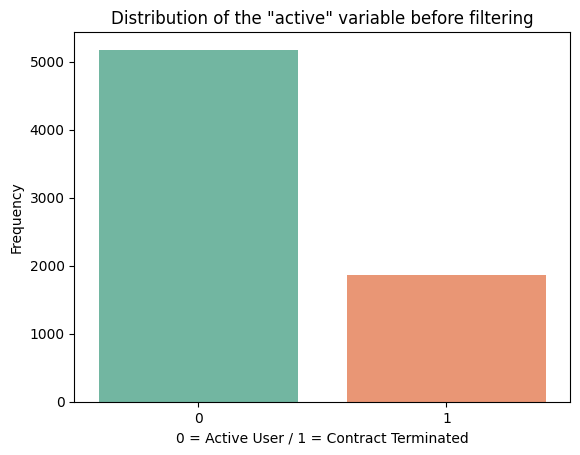

In [89]:
# Plot the class imbalance
sns.barplot(x=active_b.index, y=active_b.values, palette='Set2')

# Adjust the plot
plt.title('Distribution of the "active" variable before filtering')
plt.xlabel('0 = Active User / 1 = Contract Terminated')
plt.ylabel('Frequency')


C:\Users\JoseC\AppData\Local\Temp\ipykernel_17120\2249876374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=active_a.index, y=active_a.values, palette='Set2')


Text(0, 0.5, 'Frequency')

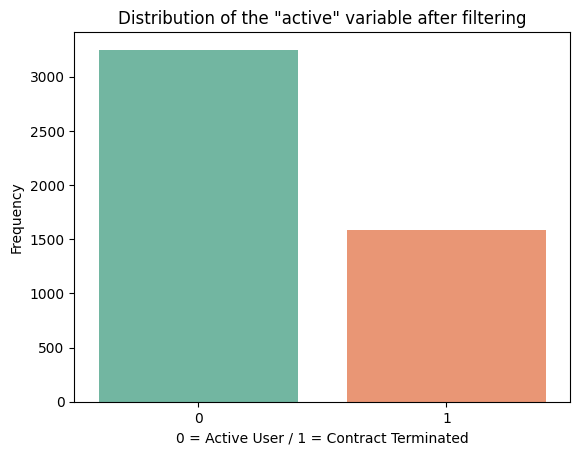

In [90]:
# Plot the class imbalance
sns.barplot(x=active_a.index, y=active_a.values, palette='Set2')

# Adjust the plot
plt.title('Distribution of the "active" variable after filtering')
plt.xlabel('0 = Active User / 1 = Contract Terminated')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

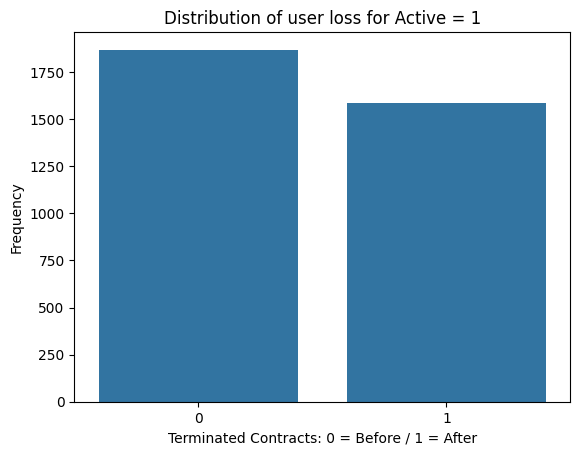

In [91]:
# Plot the loss of users who terminated their contracts
sns.barplot(x=inactive_values.index, y='values', data=inactive_values)

# Adjust the plot
plt.title('Distribution of user loss for Active = 1')
plt.xlabel('Terminated Contracts: 0 = Before / 1 = After')
plt.ylabel('Frequency')

Remarks
 - We can notice that the percentage of rows with active = 1 did not decrease significantly, so this will help eliminate any rows containing NaN values that could interfere with the models. If the remaining values are insufficient, overfitting could be applied to increase the quantity.

In [92]:
# Proceed to convert all columns to 'YES' = 1, 'NO' = 0
bool_vals = ['partner', 'dependents', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 
             'streamingtv', 'streamingmovies', 'multiplelines']
telecom_df[bool_vals] = telecom_df[bool_vals].replace({'Yes': 1, 'No': 0})

# Convert other columns
telecom_df['gender'] = telecom_df['gender'].replace({'Female': 1, 'Male': 0})
telecom_df['internetservice'] = telecom_df['internetservice'].replace({'DSL': 1, 'Fiber optic': 0})

telecom_df['seniorcitizen'] = telecom_df['seniorcitizen'].astype('int64')
telecom_df['totalcharges'] = pd.to_numeric(telecom_df['totalcharges'], errors='coerce')

# Apply ONE-HOT-ENCODING for 'type'
ohe = pd.get_dummies(telecom_df['type'])
ohe = ohe.astype('int64')
telecom_df = pd.concat([telecom_df, ohe], axis='columns')

# Apply ONE-HOT-ENCODING for 'paymentmethod'
ohe = pd.get_dummies(telecom_df['paymentmethod'])
ohe = ohe.astype('int64')
telecom_df = pd.concat([telecom_df, ohe], axis='columns')

# Proceed to drop the 'type' and 'paymentmethod' columns
telecom_df = telecom_df.drop(columns=['type', 'paymentmethod'])

# Drop NaN values, removing any remaining NaN values
telecom_df = telecom_df.dropna(axis=0, how='any')

C:\Users\JoseC\AppData\Local\Temp\ipykernel_17120\247762727.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  telecom_df[bool_vals] = telecom_df[bool_vals].replace({'Yes': 1, 'No': 0})
C:\Users\JoseC\AppData\Local\Temp\ipykernel_17120\247762727.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  telecom_df['gender'] = telecom_df['gender'].replace({'Female': 1, 'Male': 0})
C:\Users\JoseC\AppData\Local\Temp\ipykernel_17120\247762727.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a futur

In [93]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4832 entries, 0 to 7041
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   active                     4832 non-null   int64  
 1   monthlycharges             4832 non-null   float64
 2   totalcharges               4832 non-null   float64
 3   gender                     4832 non-null   int64  
 4   seniorcitizen              4832 non-null   int64  
 5   partner                    4832 non-null   int64  
 6   dependents                 4832 non-null   int64  
 7   internetservice            4832 non-null   int64  
 8   onlinesecurity             4832 non-null   int64  
 9   onlinebackup               4832 non-null   int64  
 10  deviceprotection           4832 non-null   int64  
 11  techsupport                4832 non-null   int64  
 12  streamingtv                4832 non-null   int64  
 13  streamingmovies            4832 non-null   int64  
 1

### Drop Columns

Columns where the data distribution is highly balanced will be discarded, as they are considered to have less significant weight.

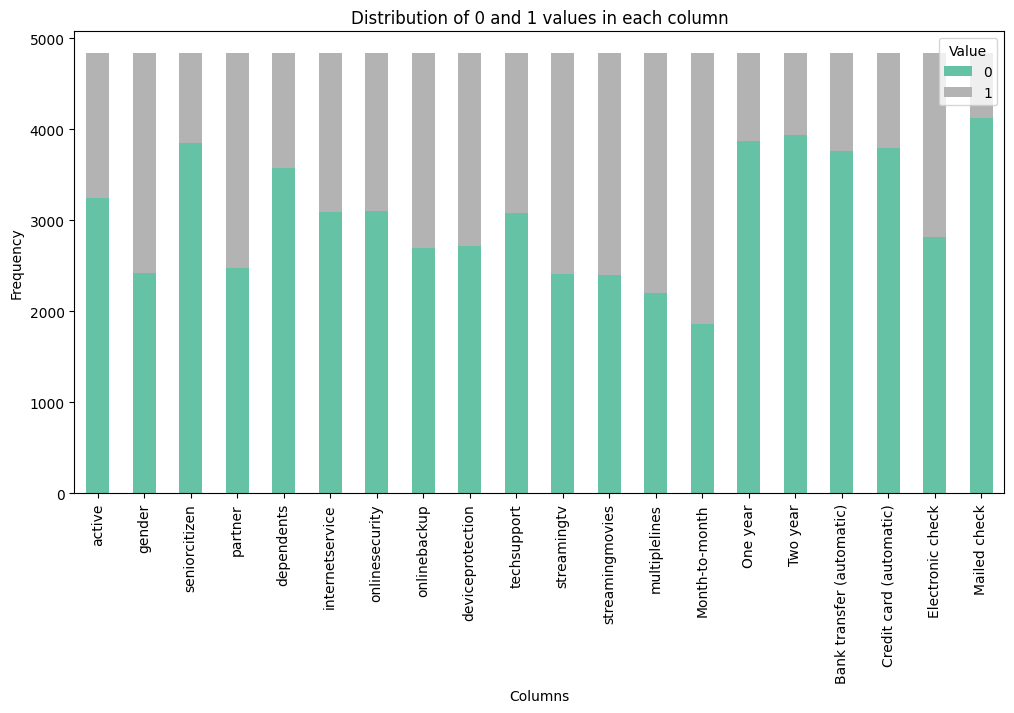

In [94]:
# Create a plot to determine which columns might have an impact on the analysis
bin_columns = telecom_df.select_dtypes(include=['int64'])

# Count the 0s and 1s in each column
counts = bin_columns.apply(pd.Series.value_counts).T

# Create a bar chart for each column
counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

# Customize the plot
plt.title('Distribution of 0 and 1 values in each column')
plt.xlabel('Columns')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(title='Value', labels=['0', '1'])

Remarks
- The goal of this plot is to identify which columns have a greater balance, as this could be a factor in not considering them in the models.
- We can notice that the columns ___gender, partner, streamingtv, streamingmovies, and multiplelines___ remain very balanced. Therefore, they will be discarded from the dataset.

In [95]:
# Drop the columns
telecom_df.drop(columns=['gender', 'partner', 'streamingtv', 'streamingmovies', 'multiplelines'], inplace=True)

# Duplicate the number of values due to the loss of rows after dropping NaN values
telecom_df = pd.concat([telecom_df, telecom_df], axis=0, ignore_index=True)

## DATA PREPARATION AND SEGMENTATION

### Data segmentation -- Training(60) - Validation(20) - Test (20)

In [96]:
# Get the 20% sample for the test data
df_remaining, df_test = train_test_split(telecom_df, test_size=0.20, random_state=1996)

# Get the 60% sample for training and 20% for validation
df_train, df_valid = train_test_split(df_remaining, test_size=0.25, random_state=1996)

### Getting Features and Targets

In [97]:
t_train = df_train['active']
f_train = df_train.drop(['active'], axis = 1)

t_valid = df_valid['active']
f_valid = df_valid.drop(['active'], axis = 1)

t_test = df_test['active']
f_test = df_test.drop(['active'], axis = 1)

In [98]:
# Validating data distribution 
total = telecom_df['active'].count()
total_target = t_train.count()
total_valid = t_valid.count()
total_test = t_test.count()

print(f"Train %: {(total_target /total)*100}")
print(f"Valid %: {(total_valid /total)*100}")
print(f"Test %: {(total_test /total)*100}")

Train %: 59.99586092715232
Valid %: 20.002069536423843
Test %: 20.002069536423843


### Oversampling (Train)

In [99]:
# Proceed to oversample the training dataset
repeat = 2 

# Filter the feature and target values
features_zeros = f_train[t_train == 0]
features_ones = f_train[t_train == 1]
target_zeros = t_train[t_train == 0]
target_ones = t_train[t_train == 1]

# Increase the quantity
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

# Shuffle the data after oversampling
f_train_up, t_train_up = shuffle(features_upsampled, target_upsampled, random_state=1996)

# Validate that the dataset has been balanced
print(t_train_up.value_counts())
    

active
0    3929
1    3738
Name: count, dtype: int64


## TRAINING MODELS

In [100]:
# Metrics Function

def model_metrics(test_values,predict_values, predict_one_values):

    acu_roc = roc_auc_score(test_values,predict_one_values)
    matrix = confusion_matrix(test_values, predict_values)
    f1 = f1_score(test_values,predict_values)

    print(f"AUC_ROC:{acu_roc} \n")
    print("Confution Matrix Results: \n" )
    print(f"VN: {matrix[0,0]}")
    print(f"FP: {matrix[0,1]}")
    print(f"VP: {matrix[1,0]}")
    print(f"FN: {matrix[1,1]} \n")
    print(f"F1 Score:{f1}")

    return acu_roc, matrix, f1

### LogisticRegression


#### Setting Model

In [101]:
lr_model = LogisticRegression(random_state=1996, solver='lbfgs')
lr_model.fit(f_train_up,t_train_up)

p_valid = lr_model.predict(f_valid)

# AUC_ROC
p_one_valid = lr_model.predict_proba(f_valid)[:, 1]



C:\Users\JoseC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Other Metrics

In [102]:
# Getting other metrics
lr_auc_roc, lr_matrix, lr_f1_score = model_metrics(t_valid,p_valid,p_one_valid)

AUC_ROC:0.8109734061263727 

Confution Matrix Results: 

VN: 925
FP: 364
VP: 153
FN: 491 

F1 Score:0.6551034022681788


### DecisionTreeClassifier

#### Hyperparameter Tuning of the Model

In [103]:
best_f1 = 0
dtc_best_depth = 0

for depth in range(1,50):

   dtc_model = DecisionTreeClassifier(random_state=1996, max_depth=depth)
   dtc_model.fit(f_train_up,t_train_up)
   
   p_valid = dtc_model.predict(f_valid)

   score = f1_score(t_valid,p_valid)

   if score > best_f1:
      best_f1 = score
      dtc_best_depth = depth
   
print(f"Best depth {dtc_best_depth}")
print(f"Best f1 {best_f1}")





Best depth 28
Best f1 0.7853810264385692


Remarks
- It can be seen that after iterating with different values, the best performing model was with __"max_depth = 28"__


#### Setting Model

In [104]:
dtc_model = DecisionTreeClassifier(random_state=1996, max_depth=28)
dtc_model.fit(f_train_up,t_train_up)

p_valid = dtc_model.predict(f_valid)

# AUC_ROC
p_one_valid = dtc_model.predict_proba(f_valid)[:, 1]

#### Other Metrics

In [105]:
# Getting Other Metrics
dtc_auc_roc, dtc_matrix, dtc_f1_score = model_metrics(t_valid,p_valid,p_one_valid)

AUC_ROC:0.8405180721730457 

Confution Matrix Results: 

VN: 1152
FP: 137
VP: 139
FN: 505 

F1 Score:0.7853810264385692


### RandomForestClassifier

#### Hyperparameter Tuning of the Model

In [106]:
best_f1 = 0
rfc_best_est = 0
rfc_best_depth = 0

for estimator in range (1,50,1):
   for depth in range(1,15):

      rfc_model = RandomForestClassifier(random_state=1996, n_estimators=estimator, max_depth = depth)
      rfc_model.fit(f_train_up,t_train_up)

      p_valid = rfc_model.predict(f_valid)

      score = f1_score(t_valid,p_valid)

      if score > best_f1:
         rfc_best_est = estimator
         best_f1 = score
         rfc_best_depth = depth

print(f"Best estimator: {rfc_best_est} ")
print(f"Best depth: {rfc_best_depth}")
print(f"Best f1: {best_f1}")

Best estimator: 49 
Best depth: 14
Best f1: 0.7852586817859674


Remarks
- It can be seen that after iterating with different values, the best performing model was __"estimator = 49"__ with __"max_depth = 14"__

#### Setting Model

In [107]:
rfc_model = RandomForestClassifier(random_state=1996, n_estimators=49, max_depth = 14)
rfc_model.fit(f_train_up,t_train_up)

#Valores para las métricas
p_valid = rfc_model.predict(f_valid)

#Valores para la mnetrica AUC_ROC
p_one_valid = rfc_model.predict_proba(f_valid)[:, 1]

#### Other Metrics

In [108]:
# Getting Other Metrics
rfc_auc_roc, rfc_matrix, rfc_f1_score = model_metrics(t_valid,p_valid,p_one_valid)

AUC_ROC:0.9192516467578025 

Confution Matrix Results: 

VN: 1076
FP: 213
VP: 90
FN: 554 

F1 Score:0.7852586817859674


### XGB Classifier

#### Hyperparameter Tuning of the Model

In [109]:
best_f1 = 0
xgb_best_est = 0
xgb_best_depth = 0

for estimator in range(1, 200, 5):
   for depth in range(1, 11):

        xgb_model = xgb.XGBClassifier(
            objective='binary:logitraw',    # For binary classification cases: binary:logistic / binary:hinge
            n_estimators=estimator,         # Number of trees in the model
            max_depth=depth,                # Maximum depth of each tree
            learning_rate=0.15,             # Learning rate [0.01-0.3], higher rate means more overfitting
            random_state=1996
        )

        xgb_model.fit(f_train_up, t_train_up)

        # Values for the metrics
        p_valid = xgb_model.predict(f_valid)

        score = f1_score(t_valid, p_valid)

        if score > best_f1:
            xgb_best_est = estimator
            best_f1 = score
            xgb_best_depth = depth

print(f"Best estimator: {xgb_best_est} ")
print(f"Best depth: {xgb_best_depth}")
print(f"Best f1: {best_f1}")


Best estimator: 196 
Best depth: 10
Best f1: 0.8120539254559873


Remarks

- It can be seen that after iterating with different values, the best performing model was __"estimator = 196"__ with __"max_depth = 10"__
- Tests were conducted with binary:logistic and binary:hinge, but ___"binary:logitraw"___ yielded better results.

#### Setting Model

In [110]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logitraw',    # For binary classification cases: binary:logistic
    n_estimators=196,               # Number of trees in the model
    max_depth=10,                    # Maximum depth of each tree
    learning_rate=0.15,             # Learning rate [0.01-0.3], higher rate means more overfitting
    random_state=1996
)

xgb_model.fit(f_train_up, t_train_up)

# Values for the metrics
p_valid = xgb_model.predict(f_valid)

# Values for the AUC-ROC metric
p_one_valid = xgb_model.predict_proba(f_valid)[:, 1]

#### Other Metrics

In [111]:
# Getting Other Metrics
xgb_auc_roc, xgb_matrix, xgb_f1_score = model_metrics(t_valid,p_valid,p_one_valid)

AUC_ROC:0.9103818020613986 

Confution Matrix Results: 

VN: 1184
FP: 105
VP: 132
FN: 512 

F1 Score:0.8120539254559873


### CatBoostClassifier

#### Hyperparameter Tuning of the Model

In [112]:
best_f1 = 0
cbc_best_i = 0
cbc_best_depth = 0

for i in range (1,100,1):
   for depth in range(1,10):
        cbc_model = CatBoostClassifier(
            iterations=i, 
            depth=depth, 
            learning_rate=0.15,
            loss_function='Logloss',
            random_state=1996,
            early_stopping_rounds=20,
            verbose = 400,
        )

        cbc_model.fit(f_train_up,t_train_up)

        p_valid = cbc_model.predict(f_valid)

        score = f1_score(t_valid,p_valid)

        if score > best_f1:
            cbc_best_i = i
            best_f1 = score
            cbc_best_depth = depth

print(f"Best estimator: {cbc_best_i} ")
print(f"Best depth: {cbc_best_depth}")
print(f"Best f1: {best_f1}")




0:	learn: 0.6669990	total: 1.08ms	remaining: 0us
0:	learn: 0.6616511	total: 1.84ms	remaining: 0us
0:	learn: 0.6605108	total: 1.28ms	remaining: 0us
0:	learn: 0.6562870	total: 1.59ms	remaining: 0us
0:	learn: 0.6563347	total: 1.71ms	remaining: 0us
0:	learn: 0.6546910	total: 2.22ms	remaining: 0us
0:	learn: 0.6545015	total: 3.48ms	remaining: 0us
0:	learn: 0.6545015	total: 4.43ms	remaining: 0us
0:	learn: 0.6545015	total: 5.77ms	remaining: 0us
0:	learn: 0.6669990	total: 1.14ms	remaining: 1.14ms
1:	learn: 0.6479261	total: 2.1ms	remaining: 0us
0:	learn: 0.6616511	total: 1.22ms	remaining: 1.22ms
1:	learn: 0.6394636	total: 2.25ms	remaining: 0us
0:	learn: 0.6605108	total: 1.64ms	remaining: 1.64ms
1:	learn: 0.6318140	total: 2.98ms	remaining: 0us
0:	learn: 0.6562870	total: 1.68ms	remaining: 1.68ms
1:	learn: 0.6290699	total: 3.08ms	remaining: 0us
0:	learn: 0.6563347	total: 2.44ms	remaining: 2.44ms
1:	learn: 0.6271431	total: 4.61ms	remaining: 0us
0:	learn: 0.6546910	total: 3.26ms	remaining: 3.26ms
1:	

Remarks
- It can be seen that after iterating with different values, the best performing model was __"estimator = 93"__ with __"max_depth = 8"__
- Tests were conducted with binary:logistic and binary:hinge, but ___"binary:logitraw"___ yielded better results.

#### Setting Model

In [120]:
cbc_model = CatBoostClassifier(
    iterations=93, 
    depth=8, 
    learning_rate=0.15,
    loss_function='Logloss',
    random_state=1996,
    early_stopping_rounds=20,
    verbose = 400,
)

cbc_model.fit(f_train_up,t_train_up)

p_valid = cbc_model.predict(f_valid)

# AUC_ROC
p_one_valid = cbc_model.predict_proba(f_valid)[:, 1]

0:	learn: 0.6545015	total: 7.68ms	remaining: 707ms
92:	learn: 0.3989240	total: 400ms	remaining: 0us


#### Other Metrics

In [121]:
# Getting Other Metrics
cbc_auc_roc, cbc_matrix, cbc_f1_score = model_metrics(t_valid,p_valid,p_one_valid)

AUC_ROC:0.8459480361780763 

Confution Matrix Results: 

VN: 985
FP: 304
VP: 136
FN: 508 

F1 Score:0.6978021978021978


## MODEL EVALUATION

In [122]:
# Creating a table with metrics and hyperparameters
model_names = ['logisticregresion','decisiontree','randomforest','xgb','catboost']
metrics = ['roc_auc','f1','hyper1','depth','VN','FP','VP','FN']
values = [
    [lr_auc_roc,lr_f1_score,'NaN','NaN',lr_matrix[0,0],lr_matrix[0,1],lr_matrix[1,0],lr_matrix[1,1]],
    [dtc_auc_roc,dtc_f1_score,'NaN',dtc_best_depth,dtc_matrix[0,0],dtc_matrix[0,1],dtc_matrix[1,0],dtc_matrix[1,1]],
    [rfc_auc_roc,rfc_f1_score,rfc_best_est,rfc_best_depth,rfc_matrix[0,0],rfc_matrix[0,1],rfc_matrix[1,0],rfc_matrix[1,1]],
    [xgb_auc_roc,xgb_f1_score,xgb_best_est,xgb_best_depth,xgb_matrix[0,0],xgb_matrix[0,1],xgb_matrix[1,0],xgb_matrix[1,1]],
    [cbc_auc_roc,cbc_f1_score,cbc_best_i,cbc_best_depth,cbc_matrix[0,0],cbc_matrix[0,1],cbc_matrix[1,0],cbc_matrix[1,1]]
]
models = pd.DataFrame(values, columns= metrics, index= model_names)

In [123]:
# Showing Data
models

,roc_auc,f1,hyper1,depth,VN,FP,VP,FN
logisticregresion,0.810973,0.655103,NaN,NaN,925,364,153,491
decisiontree,0.840518,0.785381,NaN,28,1152,137,139,505
randomforest,0.919252,0.785259,49,14,1076,213,90,554
xgb,0.910382,0.812054,196,10,1184,105,132,512
catboost,0.845948,0.697802,93,8,985,304,136,508


## BEST MODEL ELECTION

Remarks

The models were tested with approximately 2000 records (target).

- It was decided to evaluate the models using two metrics: ___F1 & Confusion Matrix___.
- Among the 5 models, XGB Classifier achieved the best F1 score.
- For the confusion matrix, considering that 1 = Contract termination, the following applies:
    - TN (True Negative) > Indicates that the user remains active.
    - FP (False Positive) > Indicates that the model predicted a user canceled the service, but the user remains active.
    - VP (True Positive) > Indicates that the user canceled the service.
    - FN (False Negative) > Indicates that the model predicted a user remains active, but the user canceled the service.

When evaluating approximately 2000 candidates, about 1 in every 4 people will not be detected by the model.



In [124]:
# Evaluating test dataset
p_valid = xgb_model.predict(f_test)

# AUC_ROC
p_one_valid = xgb_model.predict_proba(f_test)[:, 1]

# Getting Other Metrics
xgb_2_auc_roc, xgb_2_matrix, xgb_2_f1_score = model_metrics(t_test,p_valid,p_one_valid)

AUC_ROC:0.9292700037876712 

Confution Matrix Results: 

VN: 1189
FP: 85
VP: 127
FN: 532 

F1 Score:0.8338557993730408


In [125]:
# Creating a comparative DF
names = ['xbg_train','xgb_test']
metrics_2 = ['roc_auc','f1','VN','FP','VP','FN']
values = [
    [xgb_auc_roc,xgb_f1_score,xgb_matrix[0,0],xgb_matrix[0,1],xgb_matrix[1,0],xgb_matrix[1,1]],
    [xgb_2_auc_roc,xgb_2_f1_score,xgb_2_matrix[0,0],xgb_2_matrix[0,1],xgb_2_matrix[1,0],xgb_2_matrix[1,1]]
]
xgb_models = pd.DataFrame(values, columns= metrics_2, index= names)


In [126]:
xgb_models

,roc_auc,f1,VN,FP,VP,FN
xbg_train,0.910382,0.812054,1184,105,132,512
xgb_test,0.929270,0.833856,1189,85,127,532


Remarks

Based on the comparison of the two datasets for the XGB model, we can observe the following:

- The F1 metric improved.
- In this case, we can see an improvement in detecting cases where the user will not terminate the contract. Additionally, it reduced the instances where the model predicted a contract termination when the customer was actually going to remain, which can help avoid offering promotional codes to users who do not intend to switch providers.
- Similarly, we observe that for the test set, the number of true positives decreased slightly, while the detection of users who canceled the contract but were not detected by the model increased slightly.

___CONCLUSION:___

The system appears to remain stable when evaluating the model with different datasets, and we have achieved a fairly decent F1 score for this model.

## SOLUTION REPORT

Below are the observations made during the task of identifying potential customers who might terminate their contract with Interconnect:

___Work Plan:___

Initially, the proposed work plan provided a solid foundation for achieving good results. A thorough exploration of the data was carried out to determine which features would be relevant and which would not for the next steps of the project. Additionally, the data preprocessing and preparation allowed us to create a final dataset (telecom_df) that was used to train the proposed ML models, and parameter tuning led to good performance, even though most models showed similar results based on the selected metrics.

Initially, accuracy was chosen as the evaluation metric. However, after conducting a brief investigation into other metrics for evaluating classification models, two metrics were ultimately selected: Confusion Matrix and F1 score. The confusion matrix is more oriented toward classifying and describing the results into four groups, while the F1 score measures performance in imbalanced models. Together, these metrics helped us identify which model performed best.

___Challenges:___

One of the main challenges encountered in improving model quality was the incorrect implementation of oversampling. During the first tests, the F1 score was in the range of 0.60 - 0.70. The main reason was that with a 2:1 data ratio, oversampling was adjusting to increase the number of users who had already terminated their contracts, which caused the imbalance to be reversed.

Once the oversampling process was corrected, most models showed an increase in their F1 score to a range of 0.70-0.80, which could be considered an acceptable performance.

___Key Steps:___

It was determined that the data exploration and treatment, along with the balancing of classes, were the key factors that enabled the models to perform well. As mentioned earlier, the models showed significant improvement once these adjustments were made.

___Conclusion:___

The model that performed best was XGB for binary classification tasks, achieving an F1 score of 0.80 on the test data and surprisingly 0.84 on the validation data, making it a notably good model.

